In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
symbols = ["NVDA", "MSFT", "IBM", "AMZN", "GOOGL", "BLK", "JPM", "V", "DIS", "NFLX"]
start_date = '2023-10-01'
end_date = '2024-01-25'
stock_data = [yf.download(symbol, start=start_date, end=end_date) for symbol in symbols]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
def returns(stock_prices):
  stock_prices = np.array(stock_prices)
  stock_returns = np.diff(stock_prices) / stock_prices[:-1]
  return stock_returns
def mean_variance(stock_returns):
  return np.mean(stock_returns), np.var(stock_returns)



In [4]:
df = pd.DataFrame()
for i in range(10):
  df[symbols[i]] = stock_data[i]["Close"]


In [5]:
stock_returns = df.pct_change().dropna()

In [6]:
return_means, return_variance, corr_matrix = stock_returns.mean(), stock_returns.var(), stock_returns.corr()

In [8]:
portfolio_simulations = 10**3
data = {}
results_mean = []
results_var = []
possible_returns = []
possible_risk = []
for i in range(portfolio_simulations):
  weights = np.random.random(len(return_means))
  weights /= np.sum(weights)
  portfolio_return = np.sum(return_means * weights)
  possible_returns.append(portfolio_return)
  portfolio_var = (np.dot(weights.T, np.dot(corr_matrix, weights)))
  if(portfolio_return in data):
    data[portfolio_return] = min(portfolio_var, data[portfolio_return])
  else:
    data[portfolio_return] = portfolio_var
  results_mean.append(portfolio_return)
  results_var.append(portfolio_var)

Text(0.5, 0, 'Risk(Variance)')

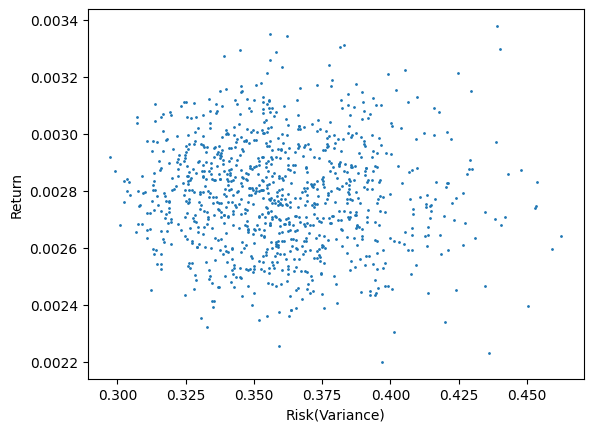

In [9]:
plt.scatter(data.values(), data.keys(), s = 1)
plt.ylabel("Return")
plt.xlabel("Risk(Variance)")


In [24]:
# Global minimum risk
C = np.array(corr_matrix)
C_inv = np.linalg.inv(C)
constant = np.ones((10, 1)).T @ (C_inv @ np.ones((10, 1)))
w = (C_inv @ np.ones((10, 1)))/constant
minimum_risk = w.T @ C @ w


In [25]:
minimum_risk

array([[0.27245545]])

In [10]:
def optimal_portfolio(corr, mean, risk, short_selling = False):
  # objective function
  def objective(W):
      return -np.dot(mean.T, W)  # negative sign for maximization
  O = np.ones((10, 1))
  # Define the constraints
  cons = ({'type': 'eq', 'fun': lambda W: np.dot(W.T, O) - 1},
          {'type': 'eq', 'fun': lambda W: np.dot(np.dot(W.T, corr), W) - risk})
  # Bounds for the weights
  if(short_selling == False):
    bounds = tuple((0.01, 1) for i in range(10))
  else:
    bounds = tuple((None, None) for i in range(10))
  x0 = np.ones(10)*0.1 # Initially assigning equal weights
  result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)
  return result.x


Text(0.5, 1.0, 'Effecient Frontier without Short Selling')

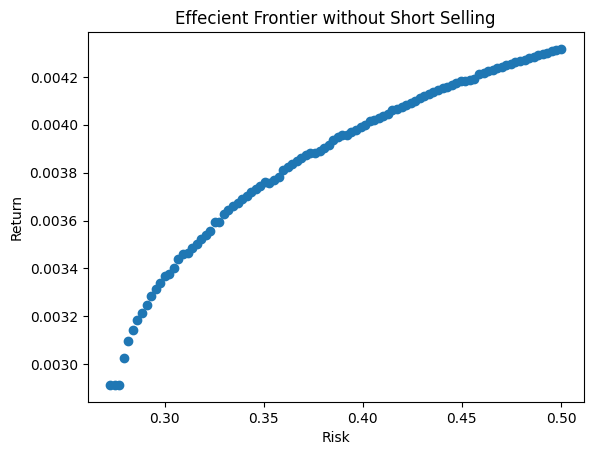

In [22]:
y = np.linspace(0.27245545, 0.5, 100) # Risk
# y = results_var
x = [] # Returns
for risk in y:
  opt_w = optimal_portfolio(corr_matrix, return_means, risk)
  max_return = np.dot(return_means.T, opt_w)
  x.append(max_return)
plt.scatter(y, x)
plt.ylabel("Return")
plt.xlabel("Risk")
plt.title("Effecient Frontier without Short Selling")

Text(0.5, 1.0, 'Effecient Frontier with Short Selling')

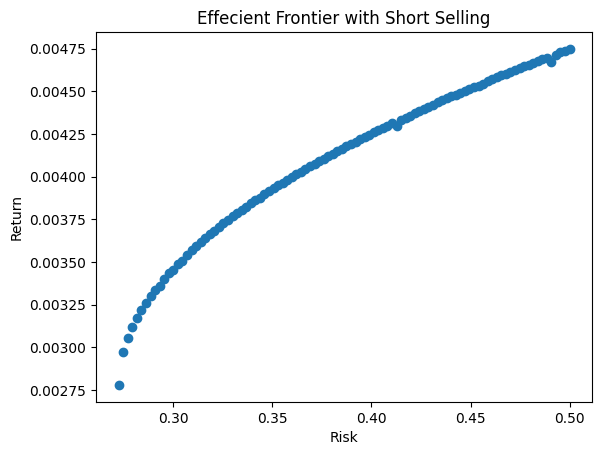

In [23]:
y = np.linspace(0.27245545, 0.5, 100) # Risk
x = [] # Returns
for risk in y:
  opt_w = optimal_portfolio(corr_matrix, return_means, risk, short_selling=True)
  max_return = np.dot(return_means.T, opt_w)
  x.append(max_return)
plt.scatter(y, x)
plt.ylabel("Return")
plt.xlabel("Risk")
plt.title("Effecient Frontier with Short Selling")

# Optimal Portfolio with risk of 0.4

In [ ]:
risk = 0.4
opt_w = optimal_portfolio(corr_matrix, return_means, risk, short_selling=True)

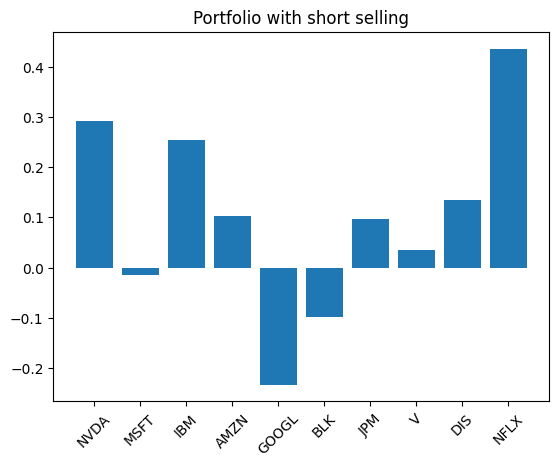

In [ ]:
plt.bar(symbols, opt_w)
plt.title("Portfolio with short selling")
plt.xticks(rotation = 45)
plt.show()

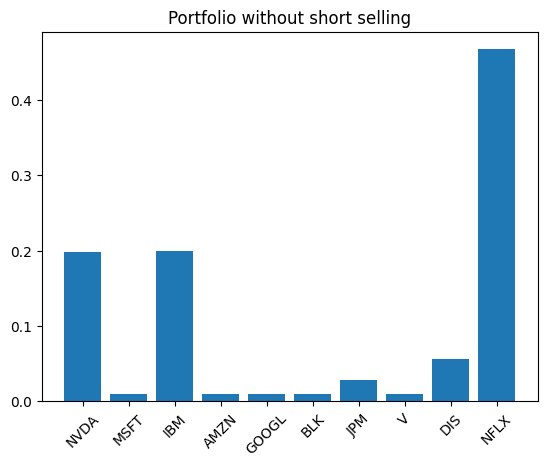

In [ ]:
opt_w = optimal_portfolio(corr_matrix, return_means, risk, short_selling=False)
plt.bar(symbols, opt_w)
plt.title("Portfolio without short selling")
plt.xticks(rotation = 45)
plt.show()